In [1]:
import os, shutil, yaml, itertools, math, wandb, sys, json
import numpy as np
import importlib
import re, math
import matplotlib.pyplot as plt
%matplotlib inline
import bitsandbytes as bnb

import torch
nn = torch.nn
F = torch.nn.functional
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

from sprelnet import train

from sprelnet import util, losses, wab, visualize
from sprelnet.data import mnist, pixels
from sprelnet.networks.relations import get_relnet
from sprelnet.networks.unet import get_unet
from sprelnet.networks.adversarial import get_adv_sprelnet
from sprelnet.networks.contrastive import get_contra_net
from sprelnet.networks.patch_net import get_patch_net

mnist.create_multi_MNIST_dataset()

pixels.create_pixel_dataset();

In [ ]:
ds = util.load_binary_file(pixel_ds_path)
ds["datapoint loader"]= lambda dp: (dp.sum(0, keepdim=True).cuda(), (dp != 0).float().cuda())
util.save_binary_file(data=ds, path=pixel_ds_path)

In [ ]:
import importlib
importlib.reload(mnist)

## Interactive

### dataset

In [12]:
coco_annot_json_dir = "/data/vision/polina/scratch/clintonw/datasets/coco/annotations"
coco_annot_json_path = os.path.join(coco_annot_json_dir, "instances_val2017.json")

In [16]:
with open(coco_annot_json_path, "r") as f:
    out = json.load(f)

In [ ]:
{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [38]:
out["annotations"][0]["bbox"]

[473.07, 395.93, 38.65, 28.67]

In [49]:
import pycocotools.mask

In [ ]:
find . -name "*.pt" -exec mv '{}' ./images/ \;

In [35]:
out["annotations"][0]["iscrowd"]

0

In [ ]:
out["categories"]

In [61]:
out["annotations"][0]["category_id"]

18

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask as cocomask
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [74]:
annType = ['segm','bbox','keypoints']
annType = annType[1]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))

Running demo for *bbox* results.


In [76]:
#initialize COCO ground truth api
dataDir='/data/vision/polina/scratch/clintonw/datasets/coco'
dataType='val2017'
annFile = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
coco=cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


In [ ]:
plt.imsave()

In [90]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
electronic animal person vehicle outdoor kitchen appliance furniture indoor accessory sports food


In [91]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

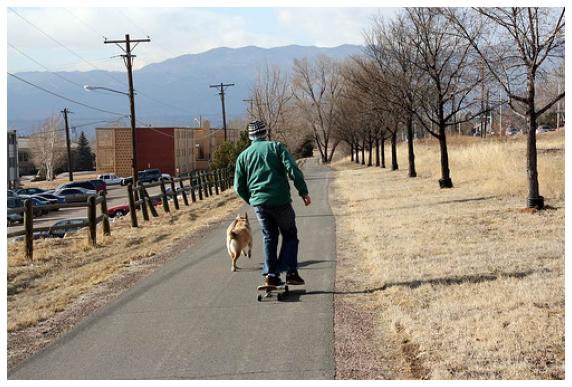

In [96]:
# load and display image
I = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [110]:
rle = cocomask.encode(mask)

In [ ]:
anns[0]

In [ ]:
ann = anns[0]

In [113]:
coco.annToMask(rle)

{'size': [334, 500],
 'counts': b']^P2555c9=N2M4L4jFQOh8[100OLQGkNk8U1UGlNm8Q1YGnNe8Q1_GnN`8Q1a0M3M12J6NIlFUOS9j0RGSOo8j0c0GXFG^9e02M4E]Tk2'}

In [112]:
rle

{'size': [334, 500],
 'counts': b']^P2555c9=N2M4L4jFQOh8[100OLQGkNk8U1UGlNm8Q1YGnNe8Q1_GnN`8Q1a0M3M12J6NIlFUOS9j0RGSOo8j0c0GXFG^9e02M4E]Tk2'}

In [111]:
coco.annToMask(rle)

KeyError: 'image_id'

In [108]:
mask = coco.annToMask(anns[0])

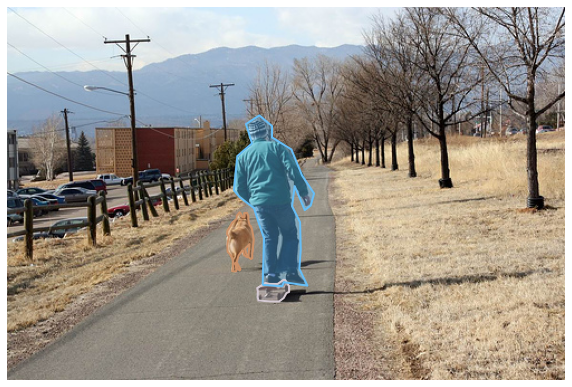

In [97]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [8]:
code_dir = "/data/vision/polina/users/clintonw/code"
mmdet_dir = f"{code_dir}/mmdet"

In [7]:
job_name = "yolov3_d53_fp16_mstrain-608_273e_coco"
model_type = "yolo"
cfg = f"configs/{model_type}/{job_name}.py"
work_dir = f"/data/vision/polina/scratch/{job_name}"
print(f"./tools/slurm_train.sh gpu {job_name} {cfg} {work_dir}")

GPUS=16 ./tools/slurm_train.sh gpu mask_r50_1x_train configs/mask_rcnn_r50_fpn_1x_coco.py /nfs/xxxx/mask_rcnn_r50_fpn_1x


In [6]:
model_type = "yolo"
job_name = "yolov3_d53_fp16_mstrain-608_273e_coco"
chckpoint = f"{code_dir}/mmdet/checkpoints/yolov3_d53_fp16_mstrain-608_273e_coco_20210517_213542-4bc34944.pth"

cfg = f"configs/{model_type}/{job_name}.py"
res_path = f"results/{job_name}.pkl"
print(f"./tools/slurm_test.sh gpu {job_name} {cfg} {chckpoint} --out {res_path}")

./tools/slurm_test.sh gpu yolov3_d53_fp16_mstrain-608_273e_coco configs/yolo/yolov3_d53_fp16_mstrain-608_273e_coco.py /data/vision/polina/users/clintonw/code/mmdet/checkpoints/yolov3_d53_fp16_mstrain-608_273e_coco_20210517_213542-4bc34944.pth --out results/yolov3_d53_fp16_mstrain-608_273e_coco.pkl


In [27]:
model_type = "faster_rcnn"
job_name = "faster_rcnn_r50_fpn_mstrain_3x_coco"
chckpoint = f"{code_dir}/mmdet/checkpoints/faster_rcnn_r50_fpn_mstrain_3x_coco_20210524_110822-e10bd31c.pth"

cfg = f"configs/{model_type}/{job_name}.py"
res_path = f"results/{job_name}.pkl"
print(f"./tools/slurm_test.sh gpu {job_name} {cfg} {chckpoint} --out {res_path}")

./tools/slurm_test.sh gpu faster_rcnn_r50_fpn_mstrain_3x_coco configs/faster_rcnn/faster_rcnn_r50_fpn_mstrain_3x_coco.py /data/vision/polina/users/clintonw/code/mmdet/checkpoints/faster_rcnn_r50_fpn_mstrain_3x_coco_20210524_110822-e10bd31c.pth --out results/faster_rcnn_r50_fpn_mstrain_3x_coco.pkl


In [9]:
import dill as pickle
import os

In [16]:
with open(os.path.join(mmdet_dir, res_path), "rb") as f:
    out = pickle.load(f)

In [23]:
len(out)

5000

In [22]:
len(out[0])

80

In [30]:
batch1 = out[0]

In [ ]:
GPUS=16 ./tools/slurm_test.sh gpu mask_r50_1x_test configs/mask_rcnn_r50_fpn_1x_coco.py /nfs/xxxx/mask_rcnn_r50_fpn_1x

### sprelnet

In [ ]:
class cmd_args:
    job_id = "van_pix"
    config_path = f"/data/vision/polina/users/clintonw/code/sprelnet/configs/{job_id}.yaml"
    p = f"{util.base_job_dir}/{job_id}"
    if not os.path.exists(p):
        os.makedirs(p)
with open(cmd_args.config_path, 'r') as stream:
    args = yaml.safe_load(stream)

run, args = train.prep_run(cmd_args, args)

if args["data loading"]["dataset"] == "MNIST grid":
    dataset = mnist.get_multi_mnist(run=run)
elif args["data loading"]["dataset"] == "pixels":
    dataset = pixels.get_pixel_dataset(run=run)
else:
    raise NotImplementedError("bad dataset")

dataloaders = util.get_dataloaders(dataset, batch_size=args["data loading"]["batch size"])

In [ ]:
if args["network"]["type"] in ["adversarial", "vanilla"]:
    get_net_fxn = get_adv_sprelnet
    train_fxn = train.train_main_relnet
elif args["network"]["type"] == "unet":
    get_net_fxn = get_unet
    train_fxn = train.train_unet
elif args["network"]["type"] == "relnet only":
    get_net_fxn = get_relnet
    train_fxn = train.train_relnet
elif args["network"]["type"] == "contrastive":
    get_net_fxn = get_contra_net
    train_fxn = train.train_contranet
elif args["network"]["type"] == "iterative with attention over patch proposals":
    get_net_fxn = get_patch_net
    train_fxn = train.train_patchnet
else:
    raise NotImplementedError("bad network type")

network = get_net_fxn(net_HPs=args["network"], dataset=dataset)
paths=args["paths"]
loss_settings=args["loss"]
optimizer_settings=args["optimizer"]

In [ ]:
model_artifact = wandb.Artifact("sprelnet", type="model", description="segmenter with spatial relations")
model_artifact.add_dir(paths["model weights directory"])

wab.define_metrics(["test loss", "test dice"])

G = network.G
relnet = network.relnet
if network.type == "adversarial":
    D = network.D_XY
loss_weights = loss_settings["weights"]

# setup dataloaders
batch_size = dataloaders["train"].batch_size
N_train = len(dataset["train datapoints"])
N_test = len(dataset["test datapoints"])
bce_loss = losses.get_bce_loss(dataset)

G_optim = bnb.optim.Adam8bit(G.parameters(), lr=float(optimizer_settings["G learning rate"]))
if network.type == "adversarial":
    DR_optim = bnb.optim.Adam8bit(itertools.chain(relnet.parameters(), D.parameters()),
        lr=float(optimizer_settings["D learning rate"]))
else:
    DR_optim = bnb.optim.Adam8bit(relnet.parameters(), lr=float(optimizer_settings["relnet learning rate"]))


for epoch in range(1, optimizer_settings["epochs"]+1):
    pxy_true_sum, pxy_fake_sum, rel_true_sum, rel_fake_sum, seg_loss_sum = 0,0, 0,0, 0
    n_batches = math.ceil(N_train/batch_size)
    rel_weight = losses.determine_loss_weight("relation score", epoch=epoch, loss_settings=loss_settings)

    for batch in dataloaders["train"]:
        X,Y_gt = batch
        Y_logits = G(X)
        seg_loss = bce_loss(Y_logits, Y_gt)

        Y_hat = torch.sigmoid(Y_logits)
        if network.type == "adversarial":
            p_xy_fake = D(X, Y_hat).mean()
            pxy_fake_sum += p_xy_fake.item()

        rel_fake = relnet(Y_hat).mean()
        rel_fake_sum += rel_fake.item()
        seg_loss_sum += seg_loss.item()

        if network.type == "adversarial":
            G_loss = seg_loss * loss_weights["cross entropy"] + rel_fake * rel_weight - p_xy_fake
        else:
            G_loss = seg_loss * loss_weights["cross entropy"] + rel_fake * rel_weight

        G_optim.zero_grad()
        G_loss.backward(retain_graph=True)
        G_optim.step()




        if network.type == "adversarial":
            p_xy_true = D(X, Y_gt).mean()
            p_xy_fake = D(X, Y_hat.detach()).mean()
            pxy_true_sum += p_xy_true.item()
        rel_true = relnet(Y_gt).mean() * loss_weights["relation score"]
        rel_true_sum += rel_true.item()

        if network.type == "adversarial":
            DR_loss = p_xy_fake - p_xy_true + rel_true
        else:
            DR_loss = rel_true

        DR_optim.zero_grad()
        DR_loss.backward()
        sparse_reg, smooth_reg = losses.get_multiscale_kernel_regs(relnet, loss_weights)
        sparse_reg.backward()
        smooth_reg.backward()
        util.mask_identity_grad_in_kernel(relnet)
        DR_optim.step()
        break
    break

## Slurm

In [ ]:
sh script_train.sh adv_mni
sh script_train.sh patch_mni
sh script_train.sh unet_mni
sh script_train.sh van_pix
sh script_train.sh van_mni
sh script_train.sh rel_dbug

In [ ]:
importlib.reload(util);

In [ ]:
util.end_slurm_jobs(["van_mni"])

In [ ]:
#util.rename_job("rel_mni", "rel_mni_01")
util.delete_job_outputs("van_pix")

In [ ]:
util.print_job_log("unet_mni")

In [ ]:
util.print_job_log("van_pix")

In [ ]:
util.print_job_log("patch_mni")

In [ ]:
util.print_job_log("rel_dbug")

In [ ]:
wab.clear_failed_runs()